# S1 Coursework

Yuanzhen Zhao (yz929)

In [1]:
import numpy as np
from scipy.integrate import quad, dblquad
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from dists import *
from scipy.optimize import brute

In [2]:
# Parameters
mu, sigma, beta, m, f, lmda, mu_b, sigma_b = 3, 0.3, 1, 1.4, 0.6, 0.3, 0, 2.5

## Question b

In [4]:
# Check if normalisation is satisfied
print(f"The CDF of g_s over the interval [0, 5] evaluates to {quad(g_s, 0, 5, args=(beta, m, mu, sigma))[0]}")
print(f"The CDF of h_s over the interval [0,10] evaluates to {quad(h_s, 0, 10, args=(lmda,))[0]}")
print(f"The CDF of g_b over the interval [0, 5] evaluates to {quad(g_b, 0, 5)[0]}")
print(f"The CDF of h_b over the interval [0, 10] evaluates to {quad(h_b, 0, 10, args=(mu_b, sigma_b))[0]}")
print(f"The CDF of s_xy over the interval [0, 5] & [0, 10] evaluates to {dblquad(s_xy, 0, 5, 0, 10, args=(beta, m, mu, sigma, lmda))[0]}")
print(f"The CDF of b_xy over the interval [0, 5] & [0, 10] evaluates to {dblquad(b_xy, 0, 5, 0, 10, args=(mu_b, sigma_b))[0]}")
print(f"The CDF of f_xy over the interval [0, 5] & [0, 10] evaluates to {dblquad(f_xy, 0, 5, 0, 10, args=(mu, sigma, beta, m, f, lmda, mu_b, sigma_b))[0]}")

The CDF of g_s over the interval [0, 5] evaluates to 1.0000000376260723
The CDF of h_s over the interval [0,10] evaluates to 1.0
The CDF of g_b over the interval [0, 5] evaluates to 1.0000000000000002
The CDF of h_b over the interval [0, 10] evaluates to 1.0
The CDF of s_xy over the interval [0, 5] & [0, 10] evaluates to 1.0000000376260723
The CDF of b_xy over the interval [0, 5] & [0, 10] evaluates to 1.0000000000000002
The CDF of f_xy over the interval [0, 5] & [0, 10] evaluates to 1.0000000225756434


## Question c

！！！三张图叠画！！！

In [5]:
x = np.linspace(0, 5, 200)
y = np.linspace(0, 10, 200)

P_x = f * g_s(x, beta, m, mu, sigma) + (1-f) * g_b(x)
P_y = f * h_s(y, lmda) + (1-f) * h_b(y, mu_b, sigma_b)

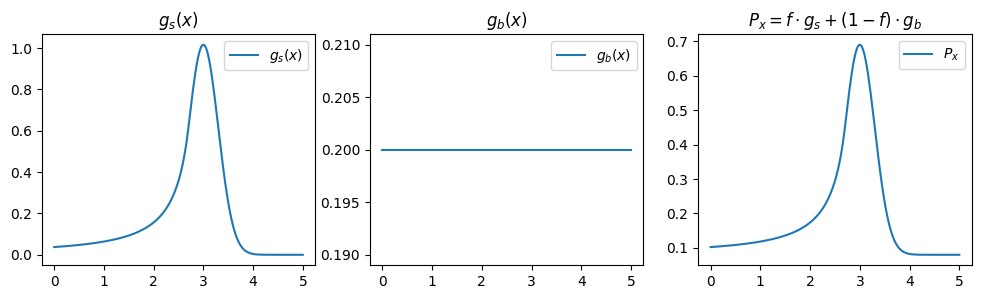

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(x, g_s(x, beta, m, mu, sigma), label='$g_s(x)$')
ax[0].set_title('$g_s(x)$')
ax[0].legend()

ax[1].plot(x, g_b(x), label='$g_b(x)$')
ax[1].set_title('$g_b(x)$')
ax[1].legend()

ax[2].plot(x, P_x, label='$P_x$')
ax[2].set_title('$P_x = f \\cdot g_s + (1-f) \\cdot g_b$')
ax[2].legend()

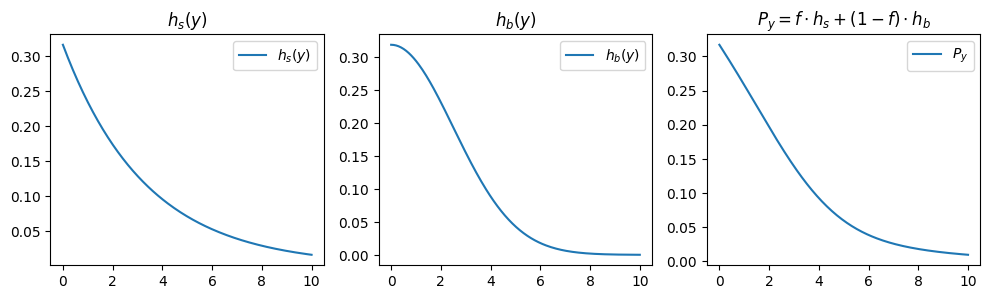

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(y, h_s(y, lmda), label='$h_s(y)$')
ax[0].set_title('$h_s(y)$')
ax[0].legend()


ax[1].plot(y, h_b(y, mu_b, sigma_b), label='$h_b(y)$')
ax[1].set_title('$h_b(y)$')
ax[1].legend()

ax[2].plot(y, P_y, label='$P_y$')
ax[2].set_title('$P_y = f \\cdot h_s + (1-f) \\cdot h_b$')
ax[2].legend()

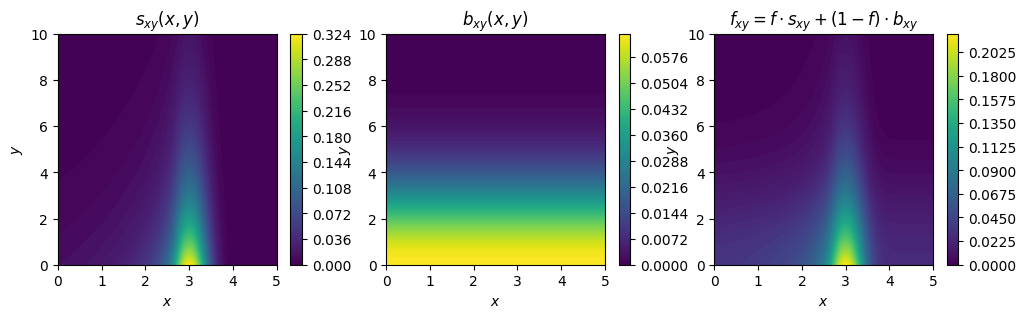

In [8]:
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

sxy = ax[0].contourf(X, Y, s_xy(Y, X, beta, m, mu, sigma, lmda), levels=100)
ax[0].set_title('$s_{xy}(x,y)$')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
fig.colorbar(sxy, ax=ax[0])

bxy = ax[1].contourf(X, Y, b_xy(Y, X, mu_b, sigma_b), levels=100)
ax[1].set_title('$b_{xy}(x,y)$')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
fig.colorbar(bxy, ax=ax[1])

fxy = ax[2].contourf(X, Y, f_xy(Y, X, mu, sigma, beta, m, f, lmda, mu_b, sigma_b), levels=100)
ax[2].set_title('$f_{xy} = f \\cdot s_{xy} + (1-f) \\cdot b_{xy}$')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$y$')
fig.colorbar(fxy, ax=ax[2])

plt.show()


## Question d

In [3]:
def unbinned_fit(samples, density, num_samples=100000):
    """Fit the model to the data using the unbinned likelihood method."""
    N = np.random.poisson(num_samples)
    nll = ExtendedUnbinnedNLL((samples[:, 0], samples[:, 1]), density)
    mi = Minuit(nll, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b=2.5, N=N)
    mi.migrad()
    mi.hesse()
    return mi

In [4]:
def density(xy, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b=2.5, N=100000):
    # Unpack the data
    x, y = xy
    return N, N*f_xy(y, x, mu, sigma, beta, m, f, lmda, mu_b, sigma_b)

Generating samples using inverse transform sampling

In [5]:
def inverse_transform_sampling(N, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b = 2.5):
    """Generate N samples from the joint distribution f_xy(x, y) using the inverse transform sampling method."""
    g_s_model = crystalball(beta=beta, m=m, loc=mu, scale=sigma)
    h_s_model = truncexpon(b=10*lmda, loc=0, scale=1/lmda)
    g_b_model = uniform(loc=0, scale=5)
    h_b_model = truncnorm(a=(0-mu_b)/sigma_b, b=(10-mu_b)/sigma_b, loc=mu_b, scale=sigma_b)
    
    Ns = int(f * N)
    Nb = int((1-f) * N)
    
    g_s_uniform_samples = np.random.uniform(g_s_model.cdf(0), g_s_model.cdf(5), size=Ns)
    Xs = g_s_model.ppf(g_s_uniform_samples) # Make sure Xs are sampled in the range [0,5]
    
    g_b_uniform_samples = np.random.uniform(g_b_model.cdf(0), g_b_model.cdf(5), size=Nb)
    Xb = g_b_model.ppf(g_b_uniform_samples) # Make sure Xb are sampled in the range [0,5]
    
    Ys = h_s_model.rvs(size=Ns)
    Yb = h_b_model.rvs(size=Nb)

    sevs = np.column_stack((Xs, Ys))
    bevs = np.column_stack((Xb, Yb))
    
    xyvalues = np.concatenate((sevs, bevs))
    
    return xyvalues

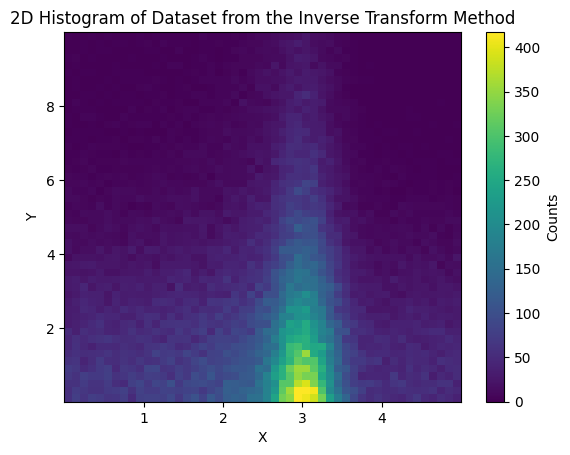

In [6]:
inverse_transform_sampling_dataset = inverse_transform_sampling(100000)

plt.hist2d(inverse_transform_sampling_dataset[:, 0], inverse_transform_sampling_dataset[:, 1], bins=[50, 50], cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram of Dataset from the Inverse Transform Method')
plt.show()

In [7]:
mi = unbinned_fit(inverse_transform_sampling_dataset, density)
display(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.46e+06                  │              Nfcn = 289              │
│ EDM = 0.000407 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu      │  2.9963   │  0.0026   │            │            │         │         │       │
│ 1 │ sigma   │  0.2996   │  0.0024   │            │            │         │         │       │
│ 2 │ beta    │   0.995   │   0.022   │            │            │         │         │       │
│ 3 │ m       │   1.42    │   0.06    │            │            │         │         │       │
│ 4 │ f       │  0.5997   │  0.0035   │            │            │         │         │       │
│ 5 │ lmda    │  0.2956   │  0.0020   │            │            │         │         │       │
│ 6 │ mu_b    │   -0.07   │   0.08    │            │            │         │         │       │
│ 7 │ sigma_b │   2.51    │   0.04    │            │            │         │         │       │
│ 8 │ N       │ 100.00e3  │  0.32e3   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │        mu     sigma      beta         m         f      lmda      mu_b   sigma_b         N │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│      mu │   6.7e-06     -3e-6    -29e-6     53e-6     -0e-6      0e-6     -2e-6      2e-6     -0e-6 │
│   sigma │     -3e-6  5.95e-06     24e-6    -50e-6      3e-6      0e-6     16e-6    -10e-6      0e-6 │
│    beta │    -29e-6     24e-6  0.000477   -1.2e-3  0.007e-3      0e-6    0.1e-3        -0         0 │
│       m │     53e-6    -50e-6   -1.2e-3    0.0039 -0.079e-3    -12e-6    -0.001    0.0003    -0.000 │
│       f │     -0e-6      3e-6  0.007e-3 -0.079e-3  1.24e-05      2e-6  0.047e-3 -0.027e-3         0 │
│    lmda │      0e-6      0e-6      0e-6    -12e-6      2e-6   4.2e-06      9e-6      4e-6     -0e-6 │
│    mu_b │     -2e-6     16e-6    0.1e-3    -0.001  0.047e-3      9e-6   0.00655   -0.0028     0.000 │
│ sigma_b │      2e-6    -10e-6        -0    0.0003 -0.027e-3      4e-6   -0.0028   0.00138   -0.0000 │
│       N │     -0e-6      0e-6         0    -0.000         0     -0e-6     0.000   -0.0000     1e+05 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [8]:
# Store the estimates and errors of the parameters
inverse_transform_sampling_estimates = {
    'mu': {'value': mi.values['mu'], 'error': mi.errors['mu']},
    'sigma': {'value': mi.values['sigma'], 'error': mi.errors['sigma']},
    'beta': {'value': mi.values['beta'], 'error': mi.errors['beta']},
    'm': {'value': mi.values['m'], 'error': mi.errors['m']},
    'f': {'value': mi.values['f'], 'error': mi.errors['f']},
    'lmda': {'value': mi.values['lmda'], 'error': mi.errors['lmda']},
    'mu_b': {'value': mi.values['mu_b'], 'error': mi.errors['mu_b']},
    'sigma_b': {'value': mi.values['sigma_b'], 'error': mi.errors['sigma_b']}
}

Accept-Reject method

In [14]:
def find_max(func, xrange, yrange, **kwargs):
    """Find the maximum of a function with two arguments over a given range"""
    f = lambda xy: -func(xy[1], xy[0], **kwargs)
    X = brute(f, [xrange, yrange])
    fmax = -f(X)
    return fmax

In [15]:
f_xy_max = find_max(f_xy, [0, 5], [0, 10], mu = 3, sigma = 0.3, beta = 1, m = 1.4, f = 0.6, lmda = 0.3, mu_b = 0, sigma_b = 2.5)

In [16]:
def accept_reject(size):
    """Generate samples from f_xy using the accept-reject method"""
    num_random = 2000000
    x_values = np.random.uniform(0, 5, num_random)
    y_values = np.random.uniform(0, 10, num_random)
    f_values = f_xy(y_values, x_values, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b = 2.5)
    u_values = np.random.uniform(0, f_xy_max, num_random)
    
    valid = u_values < f_values
    
    valid_sample = np.column_stack((x_values[valid], y_values[valid]))
    
    return valid_sample[:size]

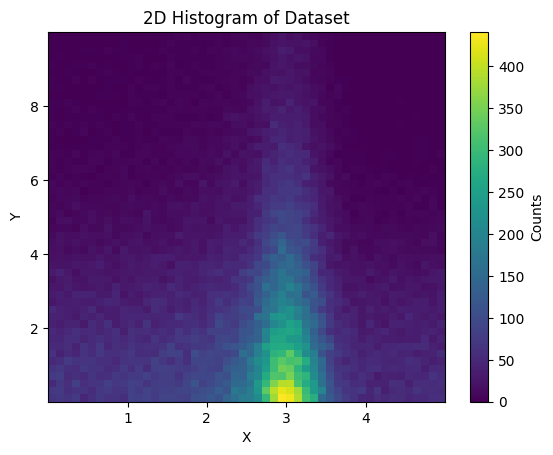

In [17]:
accept_reject_dataset = accept_reject(100000)
plt.hist2d(accept_reject_dataset[:, 0], accept_reject_dataset[:, 1], bins=[50, 50], cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram of Dataset')
plt.show()

In [18]:
mi = unbinned_fit(accept_reject_dataset, density)
display(mi)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.462e+06                 │              Nfcn = 359              │
│ EDM = 0.00103 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu      │  2.9996   │  0.0025   │            │            │         │         │       │
│ 1 │ sigma   │  0.2983   │  0.0024   │            │            │         │         │       │
│ 2 │ beta    │   1.009   │   0.023   │            │            │         │         │       │
│ 3 │ m       │   1.39    │   0.06    │            │            │         │         │       │
│ 4 │ f       │   0.600   │   0.004   │            │            │         │         │       │
│ 5 │ lmda    │  0.3023   │  0.0021   │            │            │         │         │       │
│ 6 │ mu_b    │   -0.06   │   0.09    │            │            │         │         │       │
│ 7 │ sigma_b │   2.51    │   0.04    │            │            │         │         │       │
│ 8 │ N       │ 100.00e3  │  0.32e3   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │        mu     sigma      beta         m         f      lmda      mu_b   sigma_b         N │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│      mu │  6.46e-06     -3e-6    -29e-6     54e-6     -0e-6     -0e-6     -3e-6      2e-6     40e-6 │
│   sigma │     -3e-6  5.74e-06     24e-6    -51e-6      3e-6      0e-6     18e-6    -11e-6    -48e-6 │
│    beta │    -29e-6     24e-6  0.000517   -1.3e-3  0.010e-3      1e-6    0.1e-3   -0.1e-3   -0.6e-3 │
│       m │     54e-6    -51e-6   -1.3e-3   0.00403 -0.085e-3    -11e-6    -0.001    0.0004     0.002 │
│       f │     -0e-6      3e-6  0.010e-3 -0.085e-3  1.26e-05      2e-6  0.059e-3 -0.034e-3 -0.044e-3 │
│    lmda │     -0e-6      0e-6      1e-6    -11e-6      2e-6  4.25e-06      9e-6      5e-6    -20e-6 │
│    mu_b │     -3e-6     18e-6    0.1e-3    -0.001  0.059e-3      9e-6   0.00732   -0.0032    -0.002 │
│ sigma_b │      2e-6    -11e-6   -0.1e-3    0.0004 -0.034e-3      5e-6   -0.0032   0.00155    0.0011 │
│       N │     40e-6    -48e-6   -0.6e-3     0.002 -0.044e-3    -20e-6    -0.002    0.0011     1e+05 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

In [19]:
# Store the estimates and errors of the parameters
accept_reject_estimates = {
    'mu': {'value': mi.values['mu'], 'error': mi.errors['mu']},
    'sigma': {'value': mi.values['sigma'], 'error': mi.errors['sigma']},
    'beta': {'value': mi.values['beta'], 'error': mi.errors['beta']},
    'm': {'value': mi.values['m'], 'error': mi.errors['m']},
    'f': {'value': mi.values['f'], 'error': mi.errors['f']},
    'lmda': {'value': mi.values['lmda'], 'error': mi.errors['lmda']},
    'mu_b': {'value': mi.values['mu_b'], 'error': mi.errors['mu_b']},
    'sigma_b': {'value': mi.values['sigma_b'], 'error': mi.errors['sigma_b']}
}

Evaluation of execution time averaged for 100 calls

In [20]:
benchmark_time = %timeit -o -n 100 -r 1 np.random.normal(size=100000)
inverse_transform_sampling_time = %timeit -o -n 100 -r 1 inverse_transform_sampling(100000)
accept_reject_time = %timeit -o -n 100 -r 1 accept_reject(100000)
fit_inverse_transform_sampling_time = %timeit -o -n 100 -r 1 unbinned_fit(inverse_transform_sampling_dataset, density)
fit_accept_reject_time = %timeit -o -n 100 -r 1 unbinned_fit(accept_reject_dataset, density)

1.33 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
18 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
585 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
10.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
11.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


In [21]:
print(f"The benchmark time is {benchmark_time.average:.6f} seconds")
print(f"The inverse transform sampling time is {inverse_transform_sampling_time.average:.6f} seconds, which is about {inverse_transform_sampling_time.average/benchmark_time.average:.2f} times the benchmark time")
print(f"The accept-reject sampling time is {accept_reject_time.average:.6f} seconds, which is about {accept_reject_time.average/benchmark_time.average:.2f} times the benchmark time")
print(f"The fitting time for the inverse transform sampling dataset is {fit_inverse_transform_sampling_time.average:.6f} seconds, which is about {fit_inverse_transform_sampling_time.average/benchmark_time.average:.2f} times the benchmark time")
print(f"The fitting time for the accept-reject sampling dataset is {fit_accept_reject_time.average:.6f} seconds, which is about {fit_accept_reject_time.average/benchmark_time.average:.2f} times the benchmark time")

The benchmark time is 0.001326 seconds
The inverse transform sampling time is 0.018001 seconds, which is about 13.58 times the benchmark time
The accept-reject sampling time is 0.585360 seconds, which is about 441.59 times the benchmark time
The fitting time for the inverse transform sampling dataset is 10.398362 seconds, which is about 7844.42 times the benchmark time
The fitting time for the accept-reject sampling dataset is 11.869181 seconds, which is about 8953.99 times the benchmark time


## Question e

对于每个sample size(比如说500)，用d问得到的fitted parameters去**生成对应数量的simulation dataset，再重新拟合（初始值为d问params）**（粗体部分重复250次）

bias = mean(250次fit的value) - d问的lmda value

expected uncertainty = mean(250次fit的error)

In [9]:
sample_sizes = [500, 1000, 2500, 5000, 10000]
num_bootstrap = 250

In [13]:
def unbinned_fit_with_fitted_parameters(samples, num_samples, mu=inverse_transform_sampling_estimates['mu']['value'], 
                                sigma=inverse_transform_sampling_estimates['sigma']['value'], 
                                beta=inverse_transform_sampling_estimates['beta']['value'], 
                                m=inverse_transform_sampling_estimates['m']['value'], 
                                f=inverse_transform_sampling_estimates['f']['value'], 
                                lmda=inverse_transform_sampling_estimates['lmda']['value'], 
                                mu_b=inverse_transform_sampling_estimates['mu_b']['value'], 
                                sigma_b=inverse_transform_sampling_estimates['sigma_b']['value']):
    """Fit the model to the data using the unbinned likelihood method"""

    N = np.random.poisson(num_samples)

    def density_fitted_parameters(xy, N=num_samples, mu=mu, sigma=sigma, beta=beta, m=m, f=f, lmda=lmda, mu_b=mu_b, sigma_b=sigma_b):
        x, y = xy
        return N, N*f_xy(y, x, mu, sigma, beta, m, f, lmda, mu_b, sigma_b)

    
    nll = ExtendedUnbinnedNLL((samples[:, 0], samples[:, 1]), density_fitted_parameters)
    mi = Minuit(nll, mu=mu, sigma=sigma, beta=beta, m=m, f=f, lmda=lmda, mu_b=mu_b, sigma_b=sigma_b, N=N)
    mi.migrad()
    mi.hesse()
    return mi

In [14]:
# I use inverse transform sampling here as it is less computationally expensive

simulation_lmda_values = []
simulation_lmda_bias = []
simulation_lmda_uncertainty = []

for sample_size in sample_sizes:
    for _ in range(num_bootstrap):
        
        simulation_lmda_values_one_sample_size = []
        simulation_lmda_uncertainty_one_sample_size = []
        
        N = np.random.poisson(sample_size)
        
        simulation_dataset = inverse_transform_sampling(sample_size, 
                                mu=inverse_transform_sampling_estimates['mu']['value'], 
                                sigma=inverse_transform_sampling_estimates['sigma']['value'], 
                                beta=inverse_transform_sampling_estimates['beta']['value'], 
                                m=inverse_transform_sampling_estimates['m']['value'], 
                                f=inverse_transform_sampling_estimates['f']['value'], 
                                lmda=inverse_transform_sampling_estimates['lmda']['value'], 
                                mu_b=inverse_transform_sampling_estimates['mu_b']['value'], 
                                sigma_b=inverse_transform_sampling_estimates['sigma_b']['value']
                                    )
        
        simulation_mi = unbinned_fit_with_fitted_parameters(simulation_dataset, sample_size)

        
    simulation_lmda_values_one_sample_size.append(simulation_mi.values['lmda'])
    simulation_lmda_uncertainty_one_sample_size.append(simulation_mi.errors['lmda'])



    simulation_lmda_values.append(np.mean(simulation_lmda_values_one_sample_size))
    simulation_lmda_bias.append(np.mean(simulation_lmda_values_one_sample_size) - inverse_transform_sampling_estimates['lmda']['value'])
    simulation_lmda_uncertainty.append(np.mean(simulation_lmda_uncertainty_one_sample_size))

C:\Users\JZ\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:11332: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
C:\Users\JZ\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:11332: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
C:\Users\JZ\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:11364: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
C:\Users\JZ\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_continuous_distns.py:11364: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
e:\Cambridge\s1_coursework\dists.py:9: RuntimeWarning: invalid value encountered in divide
  return cb.pdf(x) / (cb.cdf(5) - cb.cdf(0))


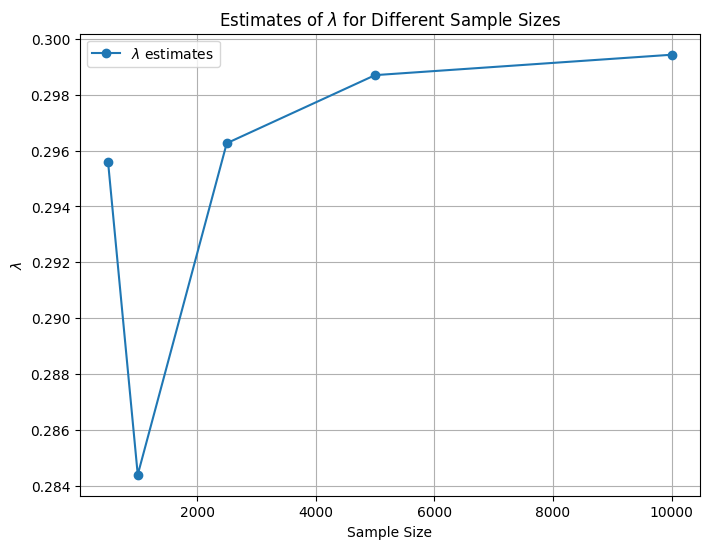

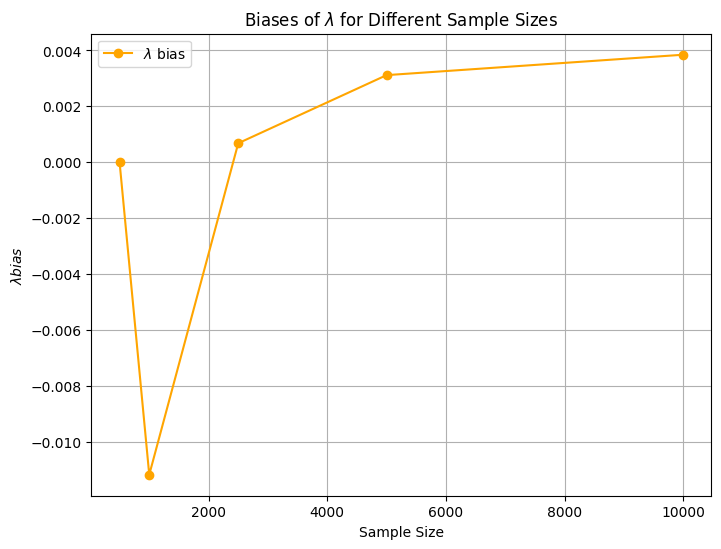

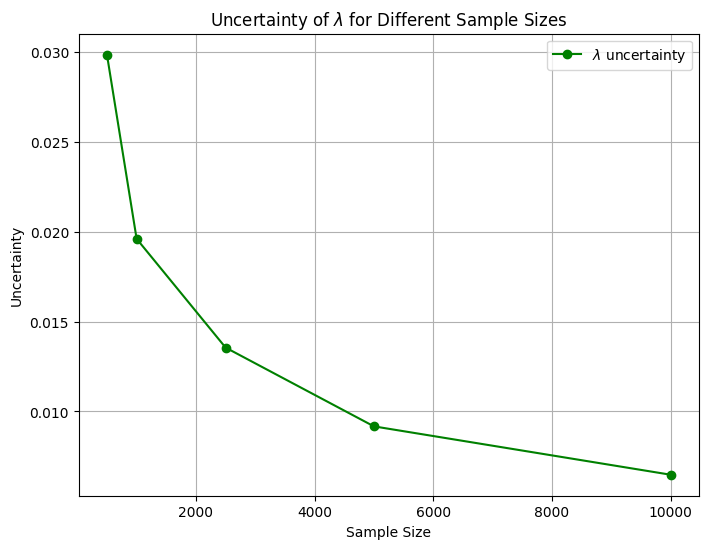

In [15]:
# Plot estimates of lambda for different sample sizes
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, simulation_lmda_values, 'o-', label='$\\lambda$ estimates')
plt.xlabel('Sample Size')
plt.ylabel('$\\lambda$')
plt.title('Estimates of $\\lambda$ for Different Sample Sizes')
plt.legend()
plt.grid(True)

# Plot biases of lambda for different sample sizes
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, simulation_lmda_bias, 'o-', label='$\\lambda$ bias', color='orange')
plt.xlabel('Sample Size')
plt.ylabel('$\\lambda bias$')
plt.title('Biases of $\\lambda$ for Different Sample Sizes')
plt.legend()
plt.grid(True)

# Plot uncertainties of lambda for different sample sizes
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, simulation_lmda_uncertainty, 'o-', label='$\\lambda$ uncertainty', color='green')
plt.xlabel('Sample Size')
plt.ylabel('Uncertainty')
plt.title('Uncertainty of $\\lambda$ for Different Sample Sizes')
plt.legend()
plt.grid(True)


In [45]:
simulation_lmda_uncertainty

[nan,
 0.010431058958208702,
 0.011452373447421981,
 0.00587491263339753,
 0.007330474000920256]

## Question f

Using the samples produced above, perform an extended maximum likelihood fit in just the $X$ variable and use it to produce `sWeights` which project out the signal
 density in 𝑌. Then use an estimation method of your choice to determine the decay
 constant 𝜆 based on the weighted sample in 𝑌. Compare the bias and the
 uncertainty to your findings from the previous part.